# Project 1
#### Marius Bjerke Stjernstedt, Eva Weiss & Kristin Fullu

This project is done to study implementation of the Finite element method from scratch. The project is divided into two parts where we study the Poisson equation first for one-dimensional and then fortwo-dimensional domains.

# One dimensional problem

The one-dimensional Poisson problem is given by
$$
\begin{align}
\begin{cases}
-u''(x)+u(x) = f(x), x\in (0,1)\\
u'(0)=u'(1)=0
\end{cases}
\end{align}
$$
for a continous function $f(x)$ on $[0,1]$. 
In this part of the project we will solve this problem using the finite element method with linear and quadratic shape functions in Python. We will also implement different types of boundary conditions.

## 1.1 Integrals over an element

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp
from time import perf_counter

### Task 1
Below is the implementation of the Integral in one dimension using Gaussian quadrature.

In [2]:
def computeIntegral1D(x0,x1,g, s):
    '''
    Computes the integral of g over the interval [x0,x1] using Gaussian quadrature
    -----------------------------------
    Input:
    x0, x1 - interval to integrate over [x_(i-1), x_i]
    g      - function to integrate
    s      - type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    I      - Integral of g over [x0,x1]
    '''


    I = 0
    h = x1-x0
    d = (x0+x1)/2

    if s==0:
        # Gaussian_Legendre
        I = h/2*( g(-h/(2*np.sqrt(3))+d)+g(h/(2*np.sqrt(3))+d) )

    if s==1:
        # Gaussian-Lobatto
        I = h/2*( 1/3*g(-h/2+d)+4/3*g(d)+1/3*g(h/2+d) )

    return I

### Task 2
Now we want to verify that the Gauss-Legendre and Gauss-Lobatto quadrature integrate polynomials of degree 3 exactly.

In [3]:
def polynomial(x):
    # Test polynomial of degree 3
    return x**3-2*x**2+2*x+4

def int_polynomial(x):
    # Integrated test polynomial
    return 1/4*x**4-2/3*x**3+x**2+4*x

#test:
Legendre = computeIntegral1D(0.5,1,polynomial, 0)
Lobatto = computeIntegral1D(0.5,1,polynomial, 1)

exact = int_polynomial(1)-int_polynomial(0.5)

print("Gaussian-Legendre: ", exact-Legendre)
print("Gaussian-Lobatto: ", exact-Lobatto)

Gaussian-Legendre:  -4.440892098500626e-16
Gaussian-Lobatto:  0.0


As we can see both quadrature rules integrate polynomials of degree 3 exactly, since the Gaussian-Lobatto output is of same order as machine error.

## 1.2 Building the load vector F

In [4]:
def LinearShapeFunctions1D(x0,x1):
    '''
    Linear shape functions and their derivatives
    -------------------------------------------
    Input:
    x0,x1  - nodes x_(i-1) , x_i where we want to compute the shape functions
    Output:
    list of linear shape functions phi_(i-1), phi_i and their derivatives on the interval [x_(i-1), x_i]
    '''
    h = x1-x0

    phi_0 = lambda x : (x1-x)/h
    phi_1 = lambda x : (x-x0)/h

    #Derivatives:
    phi_0_deriv = lambda x : -1/h
    phi_1_deriv = lambda x : 1/h

    return [phi_0, phi_1, phi_0_deriv, phi_1_deriv]

def QuadraticShapeFunctions1D(x0,x1):
    '''
    Quadratic shape functions and their derivatives
    -------------------------------------------
    Input:
    x0,x1  - nodes x_(i-1) , x_i where we want to compute the shape functions
    Output:
    list of quadratic shape functions phi_(i-1), phi_i and their derivatives on the interval [x_(i-1), x_i]
    '''
    xmid = (x1+x0)/2   # Midpoint between x0 and x1

    phi_0 = lambda x : (x-xmid)*(x-x1)/((x0-xmid)*(x0-x1))
    phi_1 = lambda x : (x-xmid)*(x-x0)/((x1-xmid)*(x1-x0))
    phi_mid = lambda x : (x-x0)*(x-x1)/((xmid-x0)*(xmid-x1))

    # Derivatives
    phi_0_deriv = lambda x : (2*x-x1-xmid)/((x0-xmid)*(x0-x1))
    phi_1_deriv = lambda x : (2*x-x0-xmid)/((x1-xmid)*(x1-x0))
    phi_mid_deriv = lambda x : (2*x-x1-x0)/((xmid-x0)*(xmid-x1))

    return [phi_0, phi_mid, phi_1, phi_0_deriv, phi_mid_deriv, phi_1_deriv]

In [5]:
def loadVector1D(mesh, p, f, s):
    '''
    Computes the load vector F
    ----------------------------
    Input:
    mesh - array of nodes
    p    - polynomial degree. 1:linear, 2:quadratic
    f    - RHS
    s    - type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    F    - Load vector
    '''

    n = len(mesh)-1      # number of elements, len(mesh) =n+1 = number of nodes

    if p==1:
        F = np.zeros(n+1)
        ShapeFunc = LinearShapeFunctions1D
        for i in range(1,n+1):
            phi_0 = ShapeFunc(mesh[i-1],mesh[i])[0]
            phi_1 = ShapeFunc(mesh[i-1],mesh[i])[1]

            I1 = computeIntegral1D(mesh[i-1],mesh[i],lambda x : f(x)*phi_0(x),s)
            I2 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: f(x)*phi_1(x),s)
            F[i-1] += I1
            F[i] += I2

    if p==2:
        F = np.zeros(2*n+1)  # Longer than mesh since we also have midpoints
        ShapeFunc = QuadraticShapeFunctions1D
        for i in range(2,2*n+1,2): #Iterate over  points (x0, x1, x2,...)

            x0 = mesh[int(i/2-1)]   # start of element (interval)
            x1 = mesh[int(i/2)]     # end of element (interval)

            phi_0 = ShapeFunc(x0,x1)[0] 
            phi_mid = ShapeFunc(x0,x1)[1]
            phi_1 = ShapeFunc(x0,x1)[2]

            I1 = computeIntegral1D(x0,x1,lambda x : f(x)*phi_0(x),s)
            I_mid = computeIntegral1D(x0,x1,lambda x : f(x)*phi_mid(x),s)
            I2 = computeIntegral1D(x0,x1,lambda x :f(x)*phi_1(x),s)
            F[i-2] += I1
            F[i-1] += I_mid
            F[i] += I2
    return F

## 1.3 Building the stiffness matrix A

### Task 1
Assembly of stiffness matrix for linear shape functions:

In [6]:
def loadMatrix1DLinear(mesh, s):
    '''
    1D load matrix A for linear shape functions
    -------------------------------------------
    Input:
    mesh - array of nodes
    s    - type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    A    - Load Matrix A for linear shape functions
    '''
    n = len(mesh)-1
    A = np.zeros((n+1,n+1))
    for i in range(1,n+1):
        phi_0, phi_1, phi_0_deriv, phi_1_deriv = LinearShapeFunctions1D(mesh[i-1],mesh[i])

        I1 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: (phi_0_deriv(x))**2 + (phi_0(x))**2,s)
        I2 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_0_deriv(x)*phi_1_deriv(x) + phi_0(x) * phi_1(x),s)
        I3 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: (phi_1_deriv(x))**2 + (phi_1(x))**2,s)

        A[i-1, i-1] += I1
        A[i-1, i]   += I2
        A[i, i-1]   += I2
        A[i, i]     += I3
    return A

### Task 2
Assembly of stiffness matrix for quadratic shape functions:

In [7]:
def loadMatrix1DQuadratic(mesh, s):
    '''
    1D load matrix A for quadratic shape functions
    ----------------------------------------------
    Input:
    mesh - nodes of our domain
    s    - type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    A    - Load Matrix A for quadratic shape functions
    '''
    n = len(mesh)-1
    A = np.zeros((2*n+1,2*n+1))

    for i in range(2,2*n+1,2): #Iterate over  points (x0, x1, x2,...)
        x0 = mesh[int(i/2-1)]   # start of element (interval)
        x1 = mesh[int(i/2)]     # end of element (interval)

        phi_0, phi_mid, phi_1, phi_0_deriv, phi_mid_deriv, phi_1_deriv = QuadraticShapeFunctions1D(x0,x1)

        I1 = computeIntegral1D(x0,x1,lambda x: (phi_0_deriv(x))**2 + (phi_0(x))**2,s)
        I2 = computeIntegral1D(x0,x1,lambda x: phi_0_deriv(x)*phi_mid_deriv(x) + phi_0(x) * phi_mid(x),s)
        I3 = computeIntegral1D(x0,x1,lambda x: phi_0_deriv(x)*phi_1_deriv(x) + phi_0(x) * phi_1(x),s)
        I4 = computeIntegral1D(x0,x1,lambda x: (phi_mid_deriv(x))**2 + (phi_mid(x))**2,s)
        I5 = computeIntegral1D(x0,x1,lambda x: phi_mid_deriv(x)*phi_1_deriv(x) + phi_mid(x)*phi_1(x),s)
        I6 = computeIntegral1D(x0,x1,lambda x: (phi_1_deriv(x))**2 + (phi_1(x))**2,s)

        A[i-2, i-2] += I1
        A[i-1, i-2] += I2
        A[i-2, i-1] += I2
        A[i-2, i]   += I3
        A[i, i-2]   += I3
        A[i-1, i-1] += I4
        A[i-1, i]   += I5
        A[i, i-1]   += I5
        A[i, i]     += I6
    return A

## 1.4 Imposition of the boundary conditions

### Task 1
Imposition of Neumann boundary condition $u'(0)=u'(1) = 1$.

In [8]:
def  applyNeumann1D(A,F,rho=None):
    '''
    Applies the Neumann boundary condition u'(0)=u'(1) = 1
    -------------------------------------------------
    Input:
    A     - Stiffness matrix
    F     - Load vector
    rho   - Needed for Neumann boundary condition, just have it here for ease of use
    Output:
    A_new - Modified stiffness matrix
    F     - Load vector
    '''
    F_new = np.copy(F)
    F_new[0] -= 1 # Neumann boundary condition i første og siste punkt fra funksjon på side 2
    F_new[-1] += 1

    return A, F_new

### Task 2
Strong and weak imposition of Dirichlet boundary condition $u(0)=u(1)=0$


In [9]:
def  applyDirichletStrongly1D(A, F,rho=None):
    '''
    Impose the Dirichlet boundary condition u(0)=u(1)=0 strongly.
    --------------------------------------------------------
    Input: 
    A     - Stiffness matrix 
    F     - Load vector 
    rho   - needed for Neumann boundary condition, just have it here for ease of use
    Output: 
    A_new - Modified stiffness matrix 
    F_new - modified load vector
    '''

    A_new = np.copy(A)
    F_new = np.copy(F)

    # u(0) = 0
    A_new[0,0] = 1
    A_new[0,1:] = 0 
    F_new[0] = 0

    # u(1) = 0
    A_new[-1,-1] = 1
    A_new[-1,:-1] = 0
    F_new[-1] = 0

    return A_new, F_new


We chose to implement the strong Dirichlet boundary condition by fixing the $u[0]$ and $u[1]$ values at the boundary. In 1D there is only one dof available per node, meaning that there is zero dof on the boundary. We do this by setting the first and last matrix rows to zero, and then letting $A_{00}=1$ and $A_{nn}=1$ and the Loadvector at $F_0=0$ and $F_n=0$.

In [10]:
def applyDirichletWeakly1D(A,F, rho = 1e8):
    '''
    Impose the Dirichlet boundary condition u(0)=u(1)=0 strongly.
    Choosing rho significantly large ensures that the first and last matrix equations ar approximately zero. 
    ------------------------------------------------------
    Input: 
    A     - Stiffness matrix 
    F     - Load vector 
    rho   - large number to enforce dirichlet BCs
    Output: 
    A_new - Modified stiffness matrix 
    F_new - modified load vector
    '''
    A_new = np.copy(A)

    A_new[0,0] += rho     # Kommentar: Dette gjør at verdien i A(0,1) kan neglisjeres, slik at man løser rho*u_0 = 1 som gir ca u_0 = 0.
    A_new[-1,-1] += rho # Lignende her

    return A_new, F # F unchanged

## 1.5 Solution of the linear system and comparison with analytical solution

### Task 1
Below is the function that will compute the solution and the $l_2$-norm of the error.

In [11]:

def computeError1D(mesh, s, p, u_exact, f, bc = None, rho=1e8):
    '''
    Assembles and solves the system and computes the L2 error
    ---------------------------------------------------------
    Input:
    mesh    - array of nodes
    s       - type of integration [0,1]
    p       - polynomial order  [1,2]
    u_exact - analytical solution
    f       - correspondingRHS
    bc      - function to impose boundary conditions
    Output:
    u_h     - computed solution in each node
    err     - L2 error
    '''
    F = loadVector1D(mesh, p, f, s)
    err_squared = 0

    if p==1:
        A = loadMatrix1DLinear(mesh, s)

    if p==2:
        A = loadMatrix1DQuadratic(mesh, s)
    

    A,F = bc(A,F,rho)   # Apply boundary condition

    u_h = spsolve(A,F)   # Faster than np.linalg.solve since A is sparse
 
    n = len(mesh)-1

    # linearshape functions
    if p==1:
        for i in range(1, n-1):
            x0 = mesh[i-1]
            x1 = mesh[i]

            u0 = u_h[i-1]
            u1 = u_h[i]

            phi_0, phi_1 = LinearShapeFunctions1D(x0, x1)[:2]
            err_squared += computeIntegral1D(x0,x1,lambda x: (u0*phi_0(x)+u1*phi_1(x)-u_exact(x))**2,s)

    # quadratic shape functions
    if p==2:
        for i in range(2,2*n+1,2): #Iterate over  points (x0, x1, x2,...)

            x0 = mesh[int(i/2-1)]   # start of element (interval)
            x1 = mesh[int(i/2)]     # end of element (interval)

            phi_0, phi_mid, phi_1 = QuadraticShapeFunctions1D(x0, x1)[:3]

            u0 = u_h[i-2]
            u1 = u_h[i-1]
            u2 = u_h[i]

            err_squared += computeIntegral1D(x0,x1,lambda x: (u0*phi_0(x)+u1*phi_mid(x)+u2*phi_1(x)-u_exact(x))**2,s)
            
    err = np.sqrt(err_squared)

    return u_h, err


### Task 2
In this task we will compare the FEM solution with the analytical solution. We will double the number of nodes multiple times to find the rate of convergence first for linear and then quadratic shape functions.

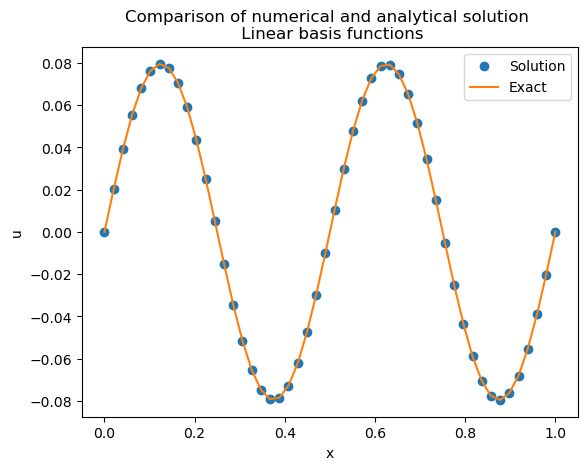

c:\Users\krist\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


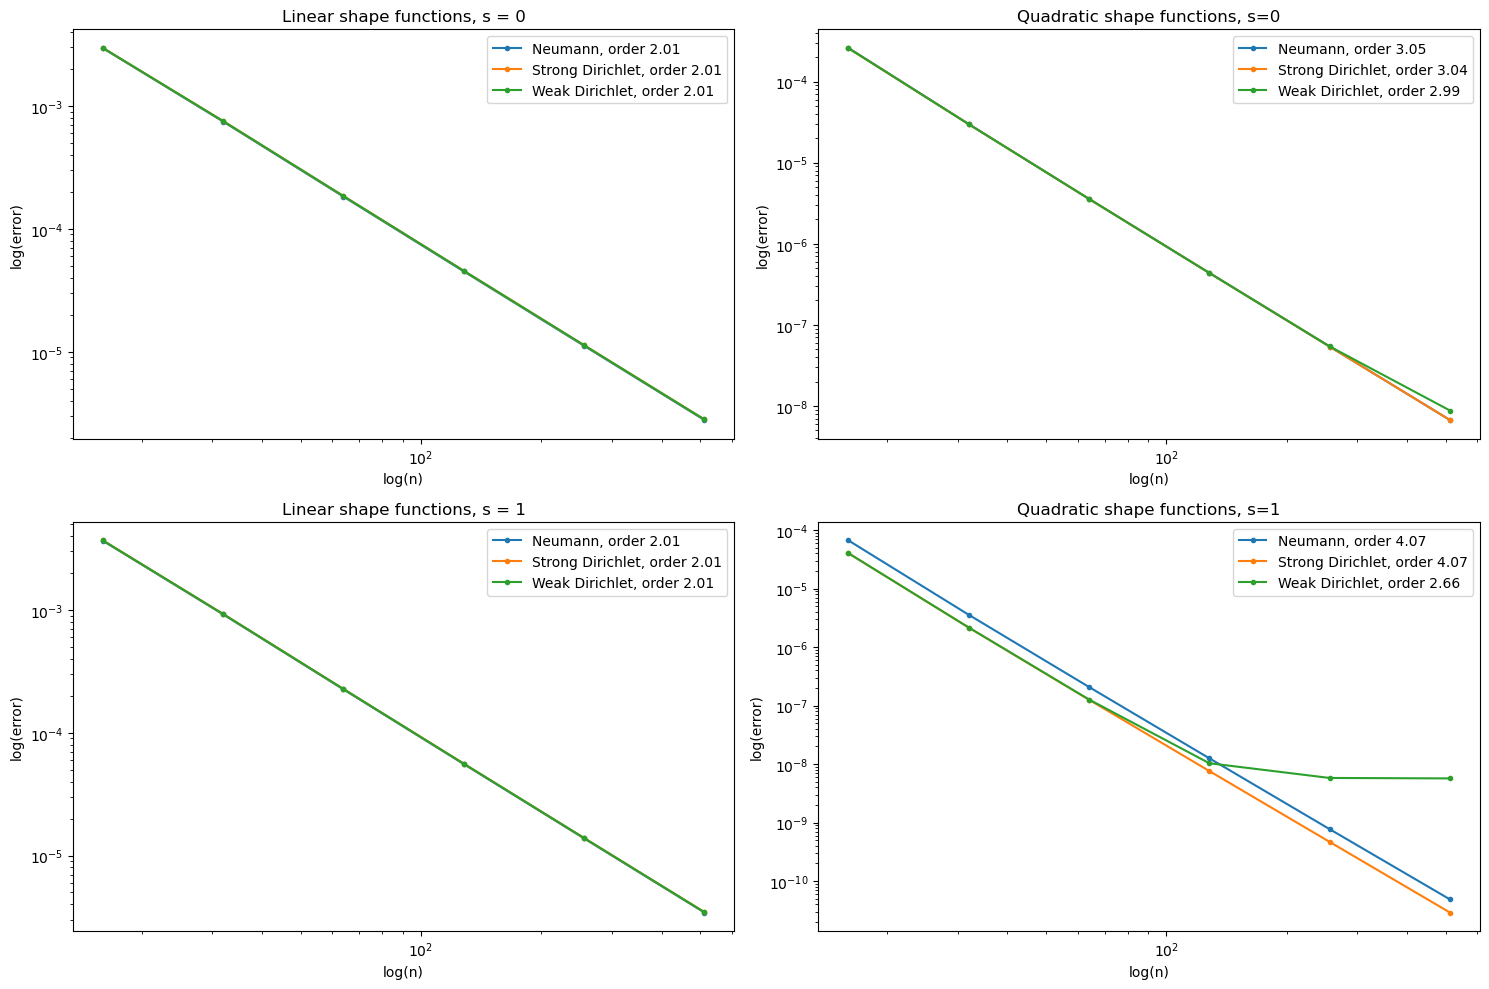

In [12]:
def u(x):
    # Exact solution
    return np.sin(4*np.pi*x)/(4*np.pi)

def f(x):
    # RHS
    return np.sin(4*np.pi*x)*(4*np.pi+1/(4*np.pi))

n_array = np.array([2**4,2**5, 2**6, 2**7, 2**8,2**9])   # Array of number of nodes


#--------------------------- PLot -------------
mesh = np.linspace(0,1,50)
F = loadVector1D(mesh, 1, f, 1)
A = loadMatrix1DLinear(mesh, 1)
A, F = applyNeumann1D(A,F)
xs = np.linalg.solve(A,F)

#x= np.linspace(0,1,100)

plt.plot(mesh, xs, 'o', label='Solution')
plt.plot(mesh,u(mesh),label='Exact')
plt.title("Comparison of numerical and analytical solution \n Linear basis functions")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()

#-----------------------Linear shape functions-------------------------------------

err_array_linear = np.zeros((len(n_array),3,2))             # Stores error for linear shape functions

# compute array for each BC.
for s in range(2):
    j=0
    for boundary_cond in [applyNeumann1D, applyDirichletStrongly1D, applyDirichletWeakly1D]:
        k = 0
        for n in n_array:
            mesh = np.linspace(0,1,n)
            u_h, err = computeError1D(mesh, s, 1, u, f, boundary_cond)
            err_array_linear[k,j,s] = err
            k+=1
        j+=1

slope_linear = np.zeros((3,2))  # Store slope for each type of BC
fig = plt.figure(figsize=(15, 10))


# Plot error and compute slope
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,2)
ax4 = fig.add_subplot(2,2,4)
ax = [ax1,ax2, ax3, ax4]

for s in range(2):
    for i in range(3):
        slope, intercept = np.polyfit(np.log(n_array), np.log(err_array_linear[:,i,s]), 1)
        slope_linear[i,s] = abs(slope)
        ax[s].loglog(n_array,err_array_linear[:,i,s],'.-')
    ax[s].legend([f"Neumann, order {slope_linear[0,s]:.2f}", f"Strong Dirichlet, order {slope_linear[1,s]:.2f}", f"Weak Dirichlet, order {slope_linear[2,s]:.2f}"])
    ax[s].set_title(f"Linear shape functions, s = {s}")
    ax[s].set_xlabel("log(n)")
    ax[s].set_ylabel("log(error)")



#-----------------------Quadratic shape functions-------------------------------------

err_array_quadratic = np.zeros((len(n_array),3,2))

# Compute array for each BC.
for s in range(2):
    j = 0
    for boundary_cond in [applyNeumann1D, applyDirichletStrongly1D, applyDirichletWeakly1D]:
        k = 0
        for n in n_array:
            mesh = np.linspace(0,1,n)
            u_h, err = computeError1D(mesh, s, 2, u, f, boundary_cond)
            err_array_quadratic[k,j,s] = err
            k+=1
        j+=1

slope_quadratic = np.zeros((3,2))   # Store slope for each type of BC.

# Plot error and compute slope for each type of BC.
for s in range(2):
    for i in range(3):
        slope, intercept = np.polyfit(np.log(n_array), np.log(err_array_quadratic[:,i,s]), 1)
        slope_quadratic[i,s] = abs(slope)
        ax[s+2].loglog(n_array,err_array_quadratic[:,i,s],'.-')
    ax[s+2].legend([f"Neumann, order {slope_quadratic[0,s]:.2f}", f"Strong Dirichlet, order {slope_quadratic[1,s]:.2f}", f"Weak Dirichlet, order {slope_quadratic[2,s]:.2f}"])
    ax[s+2].set_title(f"Quadratic shape functions, s={s}")
    ax[s+2].set_xlabel("log(n)")
    ax[s+2].set_ylabel("log(error)")
plt.tight_layout()
plt.show()


In [13]:
def f2(x):
    return 1/x

mesh = np.linspace(0,1,10)

A = loadMatrix1DLinear(mesh, 1)
F = loadVector1D(mesh, 1, f2, 1)
print("load vector : \n",F)

u_h = spsolve(A,F)
print("solution : \n",u_h)

load vector : 
 [       inf        nan 0.52222222 0.33968254 0.2526455  0.2013468
 0.16744367 0.14334554 0.1253268  0.0577342 ]
solution : 
 [nan nan nan nan nan nan nan nan nan nan]


C:\Users\krist\AppData\Local\Temp\ipykernel_12744\890802021.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/x
C:\Users\krist\AppData\Local\Temp\ipykernel_12744\3972576876.py:24: RuntimeWarning: invalid value encountered in double_scalars
  I2 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: f(x)*phi_1(x),s)


When we use gaussian quadrature to solve the integral we get the division by zero error. This then causes the value in the load vector corresponding to $\phi_0$ to go to infinity and we cannot solve the linear system. (And the value corresponding to $\phi_1$ is nan since we get $0\cdot\infty$ which is not defined.)
The reason is that the right hand side is not in $L^2$. The problem could still be well defined, though. Using the Ritz Representation theorem, we can see that f(v) only needs to be in the dual space of $H^1$, which is larger than $H^1$, and thus it is possible for the problem to be well defined.


### Bonus questions
**The choice of integration rules of order 3 is not random, it’s a minimum requirement, why?**
For linear shape functions, the highest degree polynomial we integrate is of order 2, since we multiply two shape-functions. For quadratic shape functions, the highest degree polynomial will be four. Integration rules of order N can integrate plynomials of degree 2N-1 exactly (Quarteroni, 2010). Thus to integrate a degree 4 polynomial exactly we need the qudrature rule of order 3 (which integrates polynomials of degree 5 exactly).

**How can you have an estimate of the convergence order of the solution
from the graphs above?**
 To estimate the convergence of the solution, we calculate the slope of the errors when log is applied to both the x and y axis of the error when doubling N multiple times. This is done in the code above. The slope gives us the order of convergence.

 **Try to reproduce the task above with both s, do you see any difference in
convergence order? If yes, why?**
We have the plots for both s=0 and s=1 above. When using s = 0, i.e. Gaussian Legendre, the convergence order for the quadratic polynomials decrease from approximately 4 to 3. This is because the method doesn't integrate exactly for polynomials of degree higher than 3. When assembling the matrix A, we get a polynomial of degree 4, and thus this poses an error when using s = 0, decreasing the convergence order. For the linear shape functions we still have order 2 convergence as we do not need to integrate functions of degree higher than 3.

**Try experiment with various values of ρ, why is the graph flattening for
big ns?**
ρ needs to be a large number such that all other elements in the row are insignificant. With bigger n there are more elements in each row and thus rho needs to be bigger to make those insignificant when solving the system $Au_h=F$.  The graph flattens since we will not have convergence as the boundary conditions are not implemented correctly with $\rho$ to small in comparison too n. See the graph below.

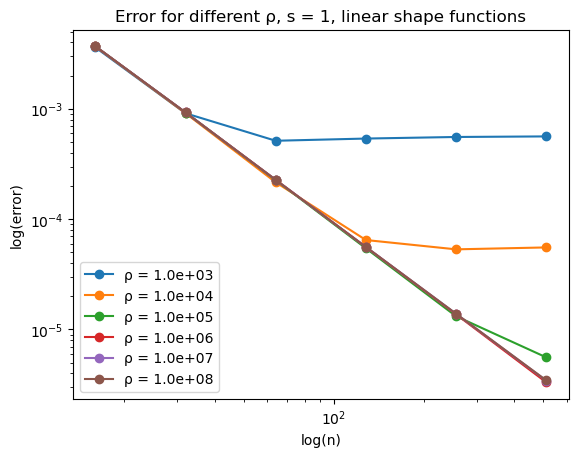

In [14]:
# try different values of ρ
rho_vec = [1e3,1e4,1e5,1e6,1e7, 1e8]
n_array = np.array([2**4,2**5, 2**6, 2**7, 2**8,2**9])

rho_err = np.zeros((len(n_array),len(rho_vec)))


j=0
for rho in rho_vec:
    i=0
    for n in n_array:
        mesh = np.linspace(0,1,n)
        u_h, err = computeError1D(mesh, 1, 1, u, f, applyDirichletWeakly1D, rho)
        rho_err[i,j] = err
        i+=1
    j+=1

r=0
for rho in rho_vec:
    plt.loglog(n_array,rho_err[:,r],'-o', label=f"ρ = {rho:.1e}")
    r+=1
    
plt.legend()
plt.title("Error for different ρ, s = 1, linear shape functions")
plt.xlabel("log(n)")
plt.ylabel("log(error)")
plt.show()

<b>Try experiment with non-uniform meshes. What is the appropriate way
to plot convergence in that case?


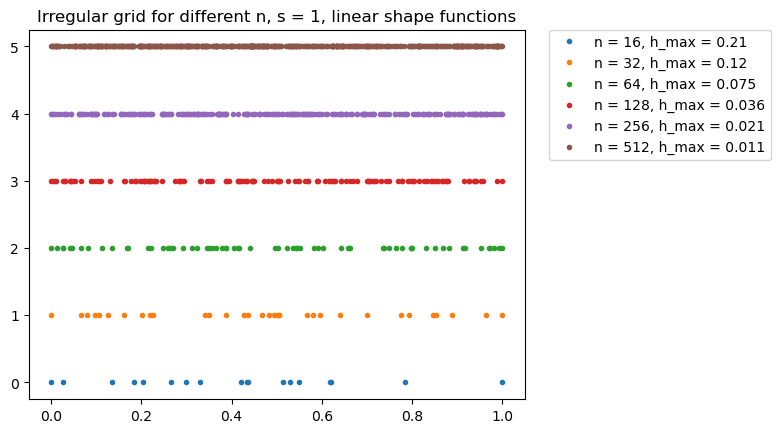

[0.21466485 0.11560165 0.07454504 0.03609255 0.02099282 0.01147307]


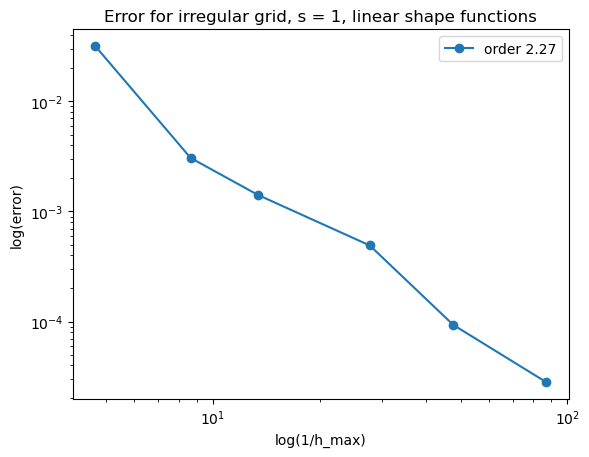

In [15]:
np.random.seed(2)
N = np.array([2**4, 2**5, 2**6, 2**7, 2**8, 2**9])
h_max = np.zeros(len(N))
err_irr = np.zeros(len(N))

for i in range(len(N)):
    mesh_irr1D = np.zeros(N[i]+2)
    mesh_irr1D[1:-1] = np.sort(np.random.rand(N[i]))
    mesh_irr1D[-1] = 1
    h_max[i] = max(abs(mesh_irr1D[:-1]-mesh_irr1D[1:]))
    u_h_irr, err_irr[i] = computeError1D(mesh_irr1D, 1, 1, u, f, bc = applyNeumann1D)
    plt.plot(mesh_irr1D, np.ones(len(mesh_irr1D))*i,'.', label = f'n = {N[i]}, h_max = {h_max[i]:.2}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Irregular grid for different n, s = 1, linear shape functions')
plt.show()

slope, intercept = np.polyfit(np.log(1/h_max), np.log(err_irr), 1)

print(h_max)
plt.loglog(1/h_max,err_irr, 'o-', label=f"order {-slope:.2f}")
plt.title('Error for irregular grid, s = 1, linear shape functions')
plt.xlabel('log(1/h_max)')
plt.ylabel('log(error)')
plt.legend()
plt.show()
# plt.plot(mesh_irr, u_h_irr, 'o')
# plt.plot(x, u(x), '-')




In the test above, we experimented with random irregular grids for different number of nodes. We assumed that the most reasonable way of comparing the error would be through the largest h, instead of number of nodes, since a big gap between nodes leads to larger errors. We see from the graph above that this is mostly the case as well. One thing to keep in mind is that it depends on the placement of nodes as well. If the nodes are closer where the exact solution has higher curvature, the error will be smaller than if there is a big gap there. 

## 2:  Two dimensional problem

### 2.1:  Weak formulation
#### Task 1

We consider the following boundary value problem (BVP):
$$
\begin{align}
\begin{cases}
- \Delta u(x,y) = f(x,y), \quad (x,y) \in(0,1)^2 \\ 
\nabla u \cdot n = g(x,y), \quad x,y \in [0,1].
\end{cases}

\end{align}
$$

We wish to find the weak formulation of (1), and proceed as follows. First, we multiply both sides by a test funciton $v$.

$$
\int_{\Omega} - \Delta uv \; = \int_{\Omega} f v \;.
$$

Next, using the divergence theorem, $\text{Div}(\nabla uv) = (\nabla u)(\nabla v)+\Delta uv,$

we get that 

$$
\int_{\Omega} \nabla u \nabla v \; - \int_{\Omega} \text{Div}(\nabla uv)\; = \int_{\Omega} f v \; \\
\Rightarrow \int_{\Omega} \nabla u \nabla v \; - \int_{\partial\Omega} \nabla uv\cdot \vec{n}\; = \int_{\Omega} f v \;.
$$

Finally, using the boundary condition from (1), we get that

$$
 \int_{\Omega} \nabla u \nabla v \; = \int_{\Omega} fv \; + \int_{\partial\Omega} gv.\;
$$

This leaves us with the following weak formulation for (1):

$$
\begin{equation}
\text{Find } u \in V \text{ such that}: \\
\end{equation}
$$
$$
a(u,v) = F(v) \quad \forall \ v \in V
$$

where

$$
a(u,v) = \int_{\Omega} \nabla u \nabla v \;, \quad \quad F(v) =\int_{\Omega} fv \; + \int_{\partial\Omega} gv\;, \quad \quad V = H^1(\Omega).
$$


#### Task 2
The Ritz-Galerkin formulation of the problem (1) can be written as

$$
\begin{equation}
\text{Find } u_h \in V_h(T_h) \text{ such that}: \\
\end{equation}
$$
$$
a(u_h,v_h) = F(v_h) \quad \forall \ v_h \in V_h(T_h)
$$

where 

$$
u_h(x,y) = \sum_{i,j=0}^n \Psi_{i,j}(x,y)u_{i,j}, \quad V_h(T_h) = \text{span}\{\Psi_i:[0,1]^2 \rightarrow \mathbb{R}: i=0,...,n \}.
$$


### 2.2 Building the stiffness matrix

#### Task 1

We want to show that $A = A_x\otimes M_y+A_y\otimes M_x$.
First, we have that 
$$
\begin{align}
A_{l(i,j),l(l,m)} = \int_{[0,1]^2}\langle \nabla \Psi_{i,j}(x,y), \nabla\Psi_{l,m}(x,y)\rangle dx dy, 
\end{align}
$$
where $l(i,j)=(n+1)\cdot j+i$.
We use that
$$
\begin{align}
\Psi_{i,j}(x,y) = \varphi_i(x)\phi_j(y)
\end{align}
$$
to rewrite
$$
A_{l(i,j),l(l,m)} = \int_{[0,1]^2}\langle \phi_j\nabla\varphi_i+\varphi_i\nabla\phi_j, \phi_m\nabla\varphi_l+\varphi_l\nabla\phi_m\rangle dx dy
$$

$$
= \int_{[0,1]^2}\langle\phi_j\nabla\varphi_i, \phi_m\nabla\varphi_l\rangle dxdy+\int_{[0,1]^2}\langle
\phi_j\nabla\varphi_i, \varphi_l\nabla\phi_m\rangle dx dy+\int_{[0,1]^2}\langle\varphi_i\nabla\phi_j,\phi_m\nabla\varphi_l\rangle dx dy+\int_{[0,1]^2}\langle\varphi_i\nabla\phi_j,\varphi_l\nabla\phi_m\rangle dx dy.
$$

Now, since  $\nabla \phi_k = [\partial_x \phi_k, 0]^T$ and $\nabla \phi_k = [0, \partial_y \phi_k]^T$, we have that the inner products  $\langle \nabla \varphi_i, \nabla \phi_m\rangle$ and $\langle \nabla\phi_j, \nabla\varphi_l \rangle$ are zero.
Thus we get that
$$
A_{l(i,j),l(l,m)} =\int_{[0,1]^2}\phi_j\phi_m\langle \nabla\varphi_i, \nabla\varphi_l\rangle dx dy+\int_{[0,1]^2}\varphi_i\varphi_l\langle \nabla\phi_j, \nabla\phi_m\rangle dx dy.
$$
 
Rewriting/applying the inner product and using the notation that $\phi_k'=\partial_y\phi_k(y)$ and $\varphi_k'=\partial_x\varphi_k(x)$ we get a new expression for each element in $A$:
$$
\begin{align}
A_{l(i,j),l(l,m)} = \int_{[0,1]^2}\big(\phi_j\phi_m\varphi_i'\varphi_l'+\varphi_i\varphi_l\phi_j'\phi_m'\big)dxdy.
\end{align}
$$

Now we take a look at the the Kronecker product $A_y\otimes M_x$.
We have that

$$(M_x)_{i,j} = \int_0^1 \varphi_i(x)\varphi_j(x)dx$$ 

and 

$$(A_y)_{l,m}=\int_0^1 \phi_l'(y)\phi_m'(y)dy.$$
In the case with linear basis functions the matrices $A_y$ and $M_x$ only has non-zero entries when $j=i-1$, $j=i$ and $j=i+1$.
From the definition of $l(i,j)$ and the Kronecker product we get that
$(A_y\otimes M_x)_{l(i,j),l(l,m)}=(A_y\otimes M_x)_{n\cdot j+i,n\cdot m+l} =(A_y)_{j,m}\cdot(M_x)_{i,l}.$
By inserting the integrals for $(A_y)_{j,m}$ and $(M_x)_{i,l}$ and then reordering we get that 
$$
\begin{align}
(A_y\otimes M_x)_{l(i,j),l(l,m)}=\int_{[0,1]^2}\phi_j'\phi_m'\cdot \varphi_i\varphi_l dxdy=\int_{[0,1]^2} \varphi_i\varphi_l\phi_j'\phi_m' dxdy.
\end{align}
$$

Similarly, using the definition of the Kronecker product and the defintions
$(M_y)_{l,m}=\int_0^1 \phi_l(y)\phi_m(y)dy$ and $(A_x)_{i,j}=\int_0^1\varphi_i'(x)\varphi_j'(x)dx$
to obtain that
$$
\begin{align}
(M_y\otimes A_x)_{l(i,j),l(l,m)}=(M_y)_{j,m}\cdot (A_x)_{i,l}=\int_{[0,1]^2}\phi_j\phi_m \varphi_i'\varphi_l'dxdy.
\end{align}
$$

Thus, by (7), (8) and (9), we see that 
$$A=M_y\otimes A_x+A_y\otimes M_x.$$

### Task 2

In [16]:
def massMatrix(mesh, s):
    '''
    Input:
    mesh: 1D grid for the problem, because we compute M_x and M_y seperately
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    M_x: Mass matrix M_x (n+1)x(n+1), works for x and y
    --------------------------------
    '''
    n = len(mesh)-1
    M_x = np.zeros((n+1,n+1))
    for i in range(1,n+1):
        phi_0, phi_1 = LinearShapeFunctions1D(mesh[i-1],mesh[i])[:2]

        I1 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_0(x)**2,s)
        I2 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_0(x) * phi_1(x),s)
        I3 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_1(x)**2,s)

        M_x[i-1, i-1] += I1
        M_x[i-1, i]   += I2
        M_x[i, i-1]   += I2
        M_x[i, i]     += I3

    return M_x

In [17]:
def stiffnessMatrix(mesh, s):
    '''
    Input:
    mesh: 1D grid for the problem, because we compute A_x and A_y seperately
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    Output:
    A_x: Stiffness matrix A_x (n+1)x(n+1),  works for x and y
    --------------------------------
    '''
    n = len(mesh)-1
    A_x = np.zeros((n+1,n+1))
    for i in range(1,n+1):
        phi_0_deriv, phi_1_deriv = LinearShapeFunctions1D(mesh[i-1],mesh[i])[2:]

        I1 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_0_deriv(x)**2,s)
        I2 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_0_deriv(x) * phi_1_deriv(x),s)
        I3 = computeIntegral1D(mesh[i-1],mesh[i],lambda x: phi_1_deriv(x)**2,s)

        A_x[i-1, i-1] += I1
        A_x[i-1, i]   += I2
        A_x[i, i-1]   += I2
        A_x[i, i]     += I3

    return A_x

## 3 Building the load vector

In [18]:
def labelMap(i,j,n):
    '''
    Input:
    i: index in x
    j: index in y
    n: number of grid points in x direction
    Output:
    corresponding index in load vector
    '''
    return (n+1)*j+i

In [19]:
def loadVector2D(mesh_x, mesh_y, s, f):
    '''
    Input:
    mesh_x: mesh in x-direction
    mesh_y: mesh in y-direction
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    f: rhs. function
    Output:
    F: Load vector F of length (nx+1)*(ny+1) for the 2D problem
    --------------------------------
    '''
    nx = len(mesh_x)-1
    ny = len(mesh_y)-1
    F = np.zeros((nx+1)*(ny+1))

    for i in range(1, nx + 1): 
        x0 = mesh_x[i - 1]
        x1 = mesh_x[i]
        phi_0, phi_1 = LinearShapeFunctions1D(x0, x1)[:2] 

        for j in range(1, ny + 1):
            y0 = mesh_y[j - 1]
            y1 = mesh_y[j]
            Phi_0, Phi_1 = LinearShapeFunctions1D(y0,y1)[:2] 
            
            # Integrate over x
            I1 = lambda y : computeIntegral1D(x0, x1, lambda x: f(x,y)*phi_0(x), s) 
            I2 = lambda y : computeIntegral1D(x0, x1, lambda x: f(x,y)*phi_1(x), s)

            # Integrate over y and add
            F[labelMap(i-1,j-1,nx)] += computeIntegral1D(y0, y1, lambda y: I1(y)*Phi_0(y), s)
            F[labelMap(i,j-1,nx)]   += computeIntegral1D(y0, y1, lambda y: I2(y)*Phi_0(y), s) 
            F[labelMap(i,j,nx)]     += computeIntegral1D(y0, y1, lambda y: I1(y)*Phi_1(y), s)
            F[labelMap(i-1,j,nx)]   += computeIntegral1D(y0, y1, lambda y: I2(y)*Phi_1(y), s)

    return F


## 4: Test problem
### Task 1

In [20]:
def u_sol(x,y):
    '''
    Analytical solution
    '''
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

def f2D(x,y):
    '''
    RHS for the 2D problem
    '''
    return 8*np.pi**2 * np.sin(2*np.pi*x)*np.sin(2*np.pi*y)


In [21]:
# Neumann boundary conditions 
# Already evaluated on the boundary, which is why cosine terms are missing (they equal 1)
# Signs stem from the normal vector

def g_right(y):
    '''
    x = 1
    '''
    return 2*np.pi*np.sin(2*np.pi*y)  # x = 1

def g_left(y):
    '''
    x = 0
    '''
    return -2*np.pi*np.sin(2*np.pi*y) # x = 0

def g_up(x):
    '''
    y = 1
    '''
    return 2*np.pi*np.sin(2*np.pi*x)  # y = 1

def g_down(x):
    '''
    y = 0
    '''
    return -2*np.pi*np.sin(2*np.pi*x) # y = 0

In [22]:
def applyNeumann2D(mesh_x, mesh_y, s, A, F):
    '''
    Input:
    mesh_x: mesh in x-direction
    mesh_y: mesh in y-direction
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    A: Stiffness matrix for the 2D problem
    F: Load vector for the 2D problem
    Output:
    A: Original A matrix, unmodified
    F_new: Modified load vector
    --------------------------------
    '''
    nx = len(mesh_x) - 1
    ny = len(mesh_y)-1

    F_new = np.copy(F)
    
    # Neumann boundary conditions, computed the same way as in the 1D load vector
    G_right = loadVector1D(mesh_y,1,g_right,s)
    G_left = loadVector1D(mesh_y,1,g_left,s)
    G_up = loadVector1D(mesh_x,1,g_up,s)
    G_down = loadVector1D(mesh_x,1,g_down,s)

    # Modify the load vector in the right places
    F_new[:labelMap(nx+1,0,nx)] += G_down
    F_new[::nx+1] += G_left
    F_new[labelMap(0,ny,nx):] += G_up
    F_new[labelMap(nx,0,nx)::nx+1] += G_right
   
    return A, F_new


### Task 2

In [23]:
def computeError2D(mesh_x,mesh_y, s, u_exact, f):
    '''
    Assembles the system and computes the l^2-error
    --------------------------------------------
    Input:
    mesh_x: 1d array for x-direction
    mesh_y: 1d array for y-direction
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    u_exact(x,y): exact solution
    f(x,y): RHS of the 2D problem
    Output:
    error: L2-error
    '''

    nx = len(mesh_x) - 1
    ny = len(mesh_y) - 1

    #Assemble the system
    A_x = stiffnessMatrix(mesh_x, s)
    A_y = stiffnessMatrix(mesh_y, s)
    M_x = massMatrix(mesh_x, s)
    M_y = massMatrix(mesh_y, s)

    A = np.kron(A_y,M_x)+np.kron(M_y,A_x)
    F = loadVector2D(mesh_x, mesh_y, s, f)

    A,F = applyNeumann2D(mesh_x, mesh_y, s, A, F)

    # Solve and modify
    u_vec = np.linalg.solve(A,F) # u coefficients
    u_vec = u_vec-np.mean(u_vec) # subtract mean

    err_squared = 0

    for i in range(1, nx+1):
        x0 = mesh_x[i - 1]
        x1 = mesh_x[i]
        phi_0, phi_1 = LinearShapeFunctions1D(x0, x1)[:2] 

        for j in range(1, ny+1):
            y0 = mesh_y[j - 1]
            y1 = mesh_y[j]
            Phi_0, Phi_1 = LinearShapeFunctions1D(y0,y1)[:2] 

            # Compute u_h according to it's definition
            u_h = lambda x,y: u_vec[labelMap(i-1,j-1,nx)]*phi_0(x)*Phi_0(y) + u_vec[labelMap(i,j-1,nx)]*phi_1(x)*Phi_0(y) + u_vec[labelMap(i-1,j,nx)]*phi_0(x)*Phi_1(y) + u_vec[labelMap(i,j,nx)]*phi_1(x)*Phi_1(y)

            # Integrate over y
            I = lambda x : computeIntegral1D(y0, y1, lambda y: (u_h(x,y) - u_exact(x,y))**2, s) 

            # Integrate over x and add
            err_squared  += computeIntegral1D(x0, x1, I , s)
    
    err = np.sqrt(err_squared)
    return np.reshape(u_vec,(ny+1,nx+1)), err



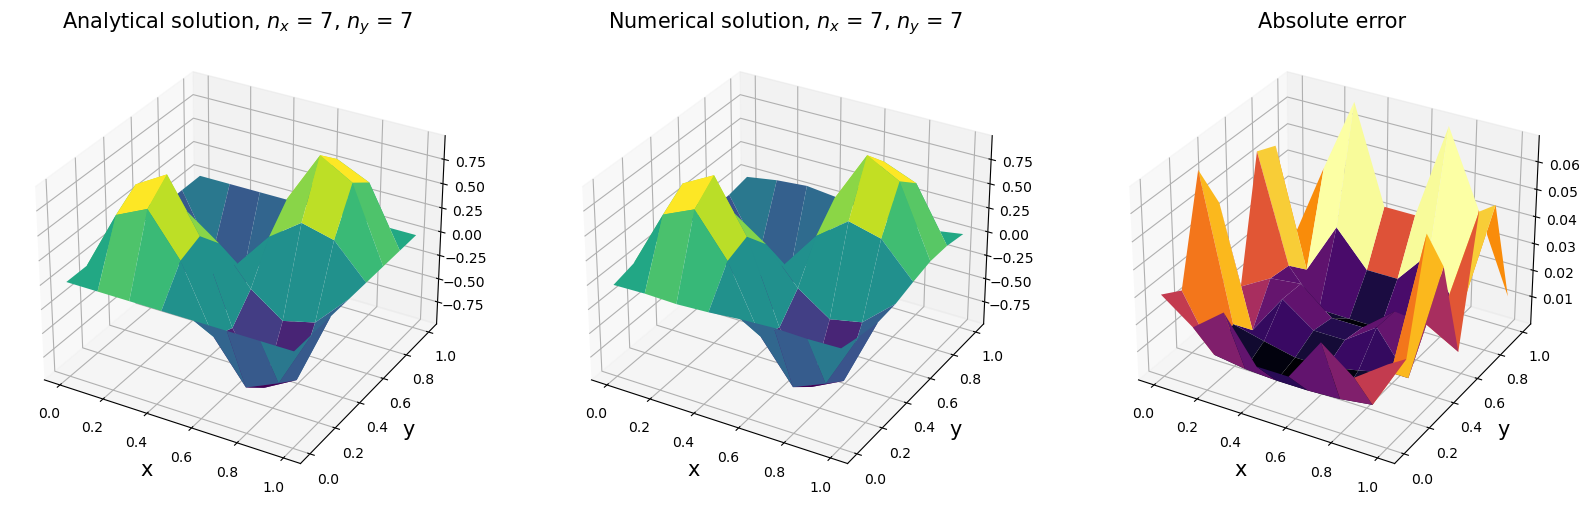

In [24]:
nx = ny = 7
xx = np.linspace(0,1,nx+1)
yy = np.linspace(0,1,ny+1)
X, Y = np.meshgrid(xx, yy)

u_num, err_= computeError2D(xx,yy, 1, u_sol, f2D)

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax1.plot_surface(X, Y, u_sol(X,Y), cmap='viridis')
ax1.set_xlabel('x', fontsize=15)
ax1.set_ylabel('y', fontsize=15)
ax1.set_title(f'Analytical solution, $n_x$ = {nx}, $n_y$ = {ny}', fontsize=15)

ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.plot_surface(X, Y, u_num, cmap='viridis')
ax2.set_xlabel('x', fontsize=15)
ax2.set_ylabel('y', fontsize=15)
ax2.set_title(f'Numerical solution, $n_x$ = {nx}, $n_y$ = {ny}', fontsize=15)

ax3 = fig.add_subplot(1,3,3, projection='3d')
ax3.plot_surface(X, Y, abs(u_sol(X,Y)-u_num), cmap='inferno')
ax3.set_xlabel('x', fontsize=15)
ax3.set_ylabel('y', fontsize=15)
ax3.set_title('Absolute error', fontsize=15)

plt.show()


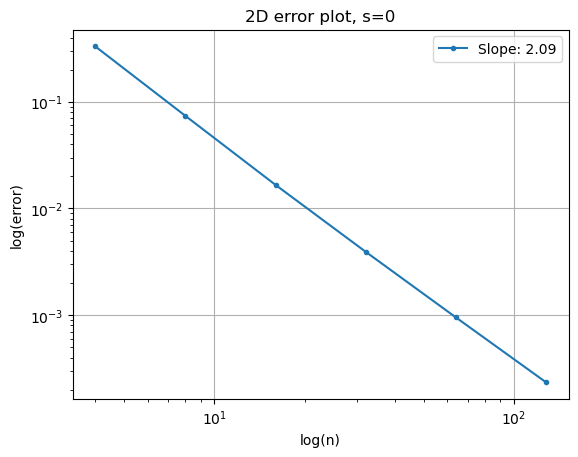

In [25]:
# Plot of the error:

N_array = np.array([2**2, 2**3, 2**4, 2**5, 2**6, 2**7])
err_array = np.zeros(len(N_array))

k = 0
for n in N_array:
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    u_h, err = computeError2D(xx,yy, 1, u_sol, f2D)
    err_array[k] = err
    k+=1


# Plot:

slope, intercept = np.polyfit(np.log(N_array), np.log(err_array), 1)
slope = abs(slope)
plt.loglog(N_array,err_array,'.-')
plt.legend([f"Slope: {slope:.2f}"])
plt.title("2D error plot, s=0")
plt.xlabel("log(n)")
plt.ylabel("log(error)")
plt.grid()
plt.show()

### Bonus questions

**How could one single out a unique solution in the case above, defined up to a constant, in other, more consistent ways?**

One possible way is to directly modify the stiffness matrix A and load vector F. It can be done by increasing the size of the vector by one zero element, and adding one row of ones at the bottom and one column of ones at the right of the matrix. In addition, the element where the row and column of ones conicide, should be set to zero. By doing this, we ensure that the sum of all $u$ coefficients is zero, and thus the mean must also be zero. The additional column of ones is there to make the matrix symmetric. After the computation of the solution, the last element of the coefficient vector should be removed.

 **Exploiting sparse matrix structure to speed up the code**

In [26]:
def AssemblyAndSol_2D(mesh_x,mesh_y, s, f):
    '''
    Assembles the system and computes the l^2-error
    --------------------------------------------
    Input:
    mesh_x: 1d array for x-direction
    mesh_y: 1d array for y-direction
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    u_exact: function, exact solution
    f: f(x,y) rhs of the problem
    Output:
    u_vec: Solution of the linear system
    AssTime: Time to do the assembly
    CompTime: Computation time to solve the linear system 
    '''
    t1 = perf_counter()

    A_x = stiffnessMatrix(mesh_x, s)
    A_y = stiffnessMatrix(mesh_y, s)
    M_x = massMatrix(mesh_x, s)
    M_y = massMatrix(mesh_y, s)

    A = np.kron(A_y,M_x)+np.kron(M_y,A_x)
    F = loadVector2D(mesh_x, mesh_y, s, f)

    A,F = applyNeumann2D(mesh_x, mesh_y, s, A, F)
    t2 = perf_counter()
    AssTime = t2-t1
    # print(f'Assembly time: {(AssTime):.5f} s')

    u_vec = np.linalg.solve(A,F) # u coefficients
    t3 = perf_counter()
    CompTime = t3-t2
    # print(f'Computation time: {(CompTime):.5f} s')

    return u_vec - np.mean(u_vec), AssTime, CompTime

def AssemblyAndSol_Sparse_2D(mesh_x,mesh_y, s, f):
    '''
    Assembles the system and computes the l^2-error
    --------------------------------------------
    Input:
    mesh_x: 1d array for x-direction
    mesh_y: 1d array for y-direction
    s: type of Gaussian quadrature. 0:Gaussian-Legendre, 1:Gaussian-Lobatto
    u_exact: function, exact solution
    f: f(x,y) rhs of the problem
    Output:
    u_vec: Solution of the linear system
    AssTime: Time to do the assembly
    CompTime: Computation time to solve the linear system 
    '''
    t1 = perf_counter()
    A_x = sp.csr_matrix(stiffnessMatrix(mesh_x, s))
    A_y = sp.csr_matrix(stiffnessMatrix(mesh_y, s))
    M_x = sp.csr_matrix(massMatrix(mesh_x, s))
    M_y = sp.csr_matrix(massMatrix(mesh_y, s))

    A = sp.kron(A_y,M_x)+sp.kron(M_y,A_x) # Must use scipy's kronecker product due to 
                                          # how the mass and stiffness matricies are strictured
    F = loadVector2D(mesh_x, mesh_y, s, f)

    A,F = applyNeumann2D(mesh_x, mesh_y, s, A, F)
    t2 = perf_counter()
    AssTime = t2-t1
    # print(f'Assembly time: {(AssTime):.5f} s')

    u_vec = spsolve(A,F) # u coefficients ### Must use spsolve due to the structure of A
    t3 = perf_counter()
    CompTime = t3-t2
    # print(f'Computation time: {(CompTime):.5f} s')

    return u_vec - np.mean(u_vec), AssTime, CompTime

c:\Users\krist\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:230: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


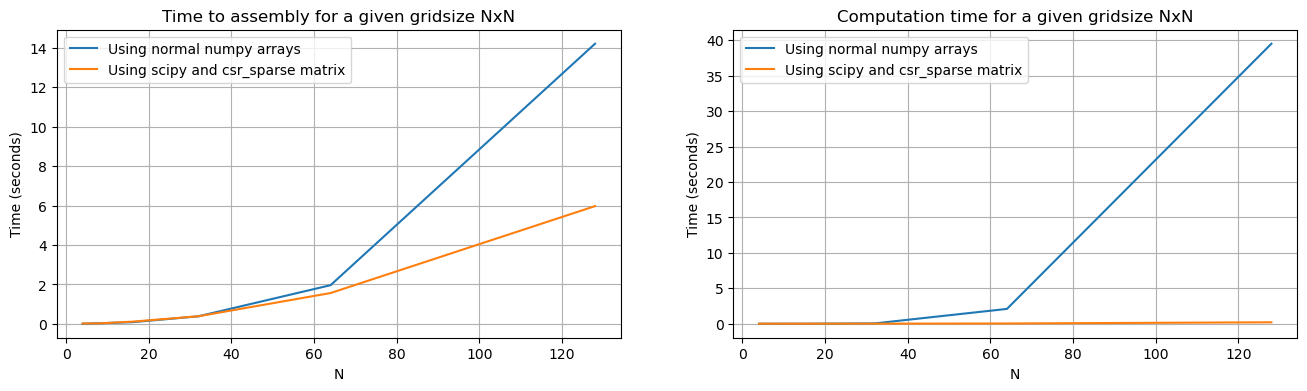

In [27]:
# Plot of the computation and assembly time:
N_array = np.array([2**2, 2**3, 2**4, 2**5, 2**6, 2**7])
err_array = np.zeros(len(N_array))
Assembly_arr_np = np.zeros(len(N_array))
Computation_arr_np = np.zeros(len(N_array))
Assembly_arr_sparse = np.zeros(len(N_array))
Computation_arr_sparse = np.zeros(len(N_array))

k = 0
for n in N_array:
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    AssTime_np, CompTime_np = AssemblyAndSol_2D(xx,yy, 1, f2D)[1:]
    AssTime_sparse, CompTime_sparse = AssemblyAndSol_Sparse_2D(xx,yy, 1, f2D)[1:]
    Assembly_arr_np[k] = AssTime_np
    Computation_arr_np[k] = CompTime_np
    Assembly_arr_sparse[k] = AssTime_sparse
    Computation_arr_sparse[k] = CompTime_sparse
    k+=1

# Plot:
fig = plt.figure(figsize=(16, 4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(N_array, Assembly_arr_np)
ax1.plot(N_array, Assembly_arr_sparse)
ax1.legend([f'Using normal numpy arrays', f'Using scipy and csr_sparse matrix'])
ax1.set_title("Time to assembly for a given gridsize NxN")
ax1.set_xlabel("N")
ax1.set_ylabel("Time (seconds)")
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(N_array, Computation_arr_np)
ax2.plot(N_array, Computation_arr_sparse)
ax2.legend([f'Using normal numpy arrays', f'Using scipy and csr_sparse matrix'])
ax2.set_title("Computation time for a given gridsize NxN")
ax2.set_xlabel("N")
ax2.set_ylabel("Time (seconds)")
ax2.grid()
plt.show()

We can see that abusing the sparsity property of the stiffness and mass matrices has a large effect on both assembly time and computation time, especially when the grid size gets larger. At smaller $N$'s we observe a minimal difference in both computation and assembly time. We saw that for the smallest $N=2^2$ the computation time for scipy is worse than for numpy, this can be due to the fact that the stiffness matrix is small and is not "sparse enough".

**Can you extend it to second order polynomials? What about mixing linear and quadratic in the two different dimensions?**

Regarding the extending to second order polynomials in both dimensions, we believe this should be possible to do. This just contructs the finite elements with this a quadratic basis, through methods similar to those in 1D. 

When it comes to mixing linear and quadratic, this poses an issue. Mainly, we see an issue with the definition of a finite element itself. Will these basises together form a basis of a finite element? This is hard to verify for us without testing. In addition, the implementation is not as straight forward as before, and would need further investiagation on our part.

**Why is the non-uniqueness of the problem not an issue for the algorithm to converge to a solution?**

When considering a numerical algorithm, one must separate the thought of uniquess in an analytical view from what the algorithm can achieve. An example that comes to mind is from an optimization course we took this spring where the solution to a problem was non-unique, but the solver was able to converge to a solution anyways. The solver used line search, and thus converged to whichever solution it was inizialized closest to. A parallell can be drawn to our case at hand, where multiple solutions exist. We can view the assembled system as an initialization, and thus the algorithm converges to the solution that is closest to this initialization. 

**Try experiment with non-uniform meshes. What is the appropriate way to plot convergence in that case?**

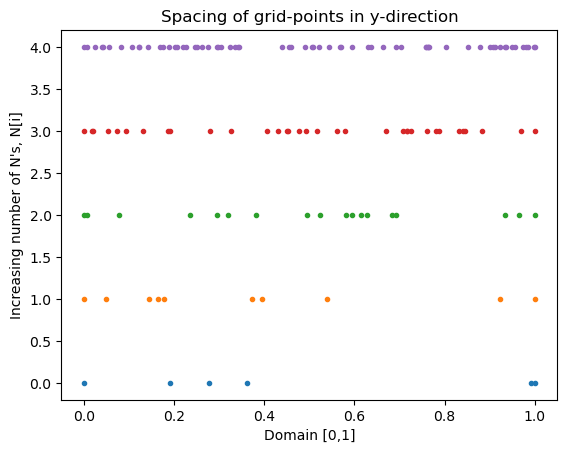

[0.62987103 0.38505003 0.23979882 0.09084432 0.09603799]


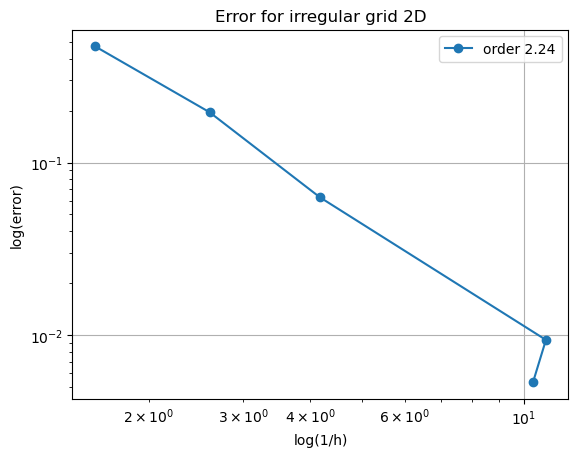

In [28]:
# Non uniform meshes
# np.random.seed(2)
N = np.array([2**2, 2**3,2**4, 2**5, 2**6])
h_max2D = np.zeros(len(N))
err_irr2D = np.zeros(len(N))

for i in range(len(N)):
    nx = ny = N[i]
    yy_irr = np.zeros(N[i]+2)
    xx = np.linspace(0,1,nx+1)
    yy_irr[1:-1] = np.sort(np.random.rand(N[i]))
    yy_irr[-1] = 1
    X, Y_irr = np.meshgrid(xx, yy_irr)

    h_max2D[i] = max(abs(yy_irr[:-1]-yy_irr[1:]))
    u_h_irr2D, err_irr2D[i] = computeError2D(xx, yy_irr, 1, u_sol, f2D)
    plt.plot(yy_irr, np.ones(len(yy_irr))*i,'.')

plt.title("Spacing of grid-points in y-direction")
plt.xlabel("Domain [0,1]")
plt.ylabel("Increasing number of N's, N[i]")
plt.show()
slope, intercept = np.polyfit(np.log(1/h_max2D), np.log(err_irr2D), 1)

print(h_max2D)
plt.loglog(1/h_max2D,err_irr2D, 'o-', label=f"order {-slope:.2f}")
plt.title('Error for irregular grid 2D')
plt.xlabel('log(1/h)')
plt.ylabel('log(error)')
plt.legend()
plt.grid()
plt.show()


## References
- Alfio Quarteroni, Riccardo Sacco, and Fausto Saleri. Numerical mathematics, volume 37. Springer Science & Business Media, 2010.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=63500965-019c-4795-b283-f306fba9f9bd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>